In [ ]:
#import the library

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import pickle 
import requests
import zipfile
import os, shutil
from PIL import Image
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
#load the data from website of matlab format
project_name='emnist-project'

In [3]:
#load the data. Rotate the image by -90 degree and then flip horizontally
def train_transform(data):
    transform = tt.Compose([lambda img: tt.functional.rotate(img, -90),
                    lambda img: tt.functional.hflip(img),
                    tt.ToTensor()])
    return transform(data)

#seperate the data to train set and data set
dataset = EMNIST(root="data/", split="byclass", train=True, transform=train_transform)
test_dataset = EMNIST(root="data/", split="byclass", train=False, transform=train_transform)

#show the datatype of dataset
print(type(dataset))

<class 'torchvision.datasets.mnist.EMNIST'>


In [4]:
#show the number of data in train set and test set
print("Total No of EMNIST dataset:", len(dataset) + len(test_dataset))
print("Training dataset:",len(dataset))
print("Testing dataset:",len(test_dataset))

Total No of EMNIST dataset: 814255
Training dataset: 697932
Testing dataset: 116323


In [5]:
#show all classes in EMNIST-ByClass 
l = dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  62
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# Convert the output index [0-61] into the character [0-9],[A-Z],[a-z]
def to_char(num):
    if num<10:
        return str(num)
    elif num < 36:
        return chr(num+55)
    else:
        return chr(num+61)

# Reverse of above function. 
# Convert the character [0-9],[A-Z],[a-z] into index [0-61]
def to_index(char):
    if ord(char)<59:
        return ord(char)-48
    elif ord(char)<95:
        return ord(char)-55
    else:
        return ord(char)-61

In [ ]:
#show the original image in dataset

In [7]:
def show_example(data):
    img, label = data
    print("Label: ("+to_char(label)+")")
    plt.imshow(img[0], cmap="gray")

In [ ]:
#Uppercase 'm' original image in dataset

Label: (M)


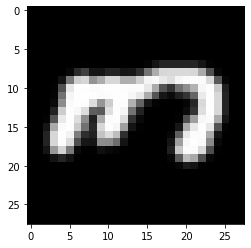

In [8]:
count = 0
for (img, label) in test_dataset:
    if label == 22:
        if count == 0:
            show_example((img,label))
            break
        count += 1

Label: (u)


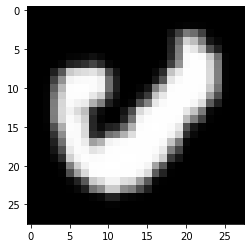

In [9]:
#lowercase 'u' original image in dataset
show_example(dataset[2200])

Label: (1)


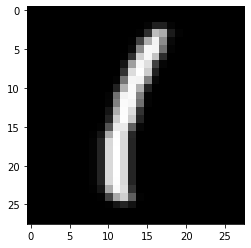

In [10]:
#Arabic numeral 1 original image in dataset
show_example(dataset[30000])

In [11]:
#DataLoader preparation
#Create Training DataLoader for training the model and Validation DataLoader for validating the model from the dataset

In [12]:
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Divide the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [13]:
#set batch_size to 200
batch_size = 200

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0)

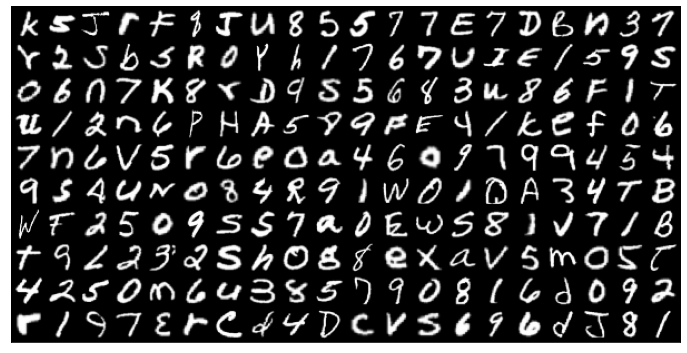

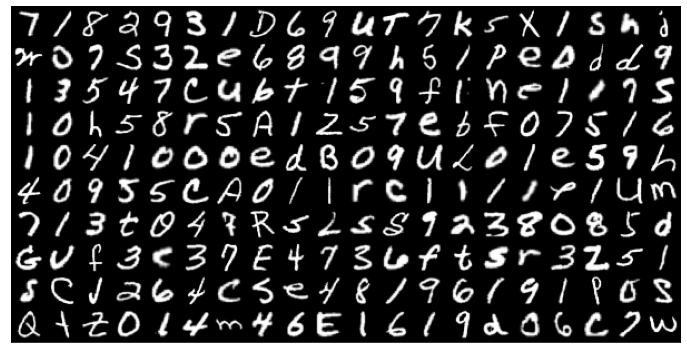

In [14]:
#show a batch of images in dataset
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break   
        
#show a batch of images in training dataset
for images, labels in train_dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break
show_batch(train_dl)

In [15]:
#LoadData into prefered Runtime Type

In [16]:
#GPU if available then pick GPU, else picking CPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
#Move tensor(s) to GPU/CPU in this devices
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#move data to the device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
# transfer the training and validation dataloader to CUDA if available 
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [18]:
#Defined the function and training step

In [19]:
#The accuray function returns the accuracy for a batch 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#The evaluate function returns the loss and accuracy over the validation or test dataset
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [20]:
#The training_step function returns the loss of a batch
class CharacterClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss

#The validation_step function returns the loss and accuracy of a batch of validation dataloader
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        _, preds = torch.max(out, dim=1)
        return {'labels': labels, 'val_pred': preds, 'val_loss': loss.detach(), 'val_acc': acc}

#The validation_epoch_end function returns combined loss and accuracy of validation dataloader for an epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs,).mean()      
        batch_preds = [x['val_pred'] for x in outputs]
        epoch_preds = torch.concat(batch_preds,dim=0)  
        batch_labels = [x['labels'] for x in outputs]
        epoch_labels = torch.concat(batch_labels,dim=0)  
        return {'labels':epoch_labels, 'val_preds':epoch_preds, 'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#The epoch_end function prints the final loss and accuray after an epoch.
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#Perform list of Convolutional Neural Networks ReLUs, MaxPools and Residual blocks

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

#ResNet9 model, inhering the CharacterClassificationBase class
class ResNet9(CharacterClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(7), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [22]:
# Creating the model
# Take 1 channel input and return 62 channel output

model = to_device(ResNet9(1, 62), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [69]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#The fit_one_cycle function returns the new features including Learning rate scheduling, Weight decay, Gradient clipping
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_loader) * 6)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
#Set the training model to true, the model will train from the beginning

In [71]:
train_model = True

In [72]:
#Set the parameters. The number of epochs are set to 16
epochs = 16
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [73]:
import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

    
history = []
if train_model:
    print("Training the model from the begning. Expected time for completion for 8 epochs is 1 hour\n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
    history_file = open('history_file.pickle', 'wb') 
    pickle.dump(history, history_file) 
    history_file.close()
    torch.save(model.state_dict(), 'emnist-resnet9.weight')
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load('emnist-resnet9.weight', map_location=get_default_device())))
    history_file = open('history_file.pickle', 'rb') 
    history = CPU_Unpickler(history_file).load()
    history_file.close()
    print()

Training the model from the begning. Expected time for completion for 8 epochs is 1 hour


Epoch [0], last_lr: 0.01000, train_loss: 0.4405, val_loss: 0.4628, val_acc: 0.8303
Epoch [1], last_lr: 0.01000, train_loss: 0.4392, val_loss: 0.4695, val_acc: 0.8306
Epoch [2], last_lr: 0.01000, train_loss: 0.4415, val_loss: 0.4704, val_acc: 0.8413
Epoch [3], last_lr: 0.01000, train_loss: 0.4413, val_loss: 0.4867, val_acc: 0.8324
Epoch [4], last_lr: 0.01000, train_loss: 0.4410, val_loss: 0.4295, val_acc: 0.8438
Epoch [5], last_lr: 0.01000, train_loss: 0.4423, val_loss: 0.4164, val_acc: 0.8503
Epoch [6], last_lr: 0.00100, train_loss: 0.3687, val_loss: 0.3529, val_acc: 0.8668
Epoch [7], last_lr: 0.00100, train_loss: 0.3557, val_loss: 0.3511, val_acc: 0.8689
Epoch [8], last_lr: 0.00100, train_loss: 0.3521, val_loss: 0.3449, val_acc: 0.8702
Epoch [9], last_lr: 0.00100, train_loss: 0.3502, val_loss: 0.3490, val_acc: 0.8708
Epoch [10], last_lr: 0.00100, train_loss: 0.3483, val_loss: 0.3498, val_acc: 0.

In [74]:
import io
result = evaluate(model, val_dl)
if train_model:
    result_file = open('result.pickle', 'wb') 
    pickle.dump(result, result_file) 
    result_file.close()
else:
    result_file = open('result.pickle', 'rb') 
    result = CPU_Unpickler(result_file).load()
    result_file.close()
print(result)

{'labels': tensor([46, 29,  3,  ..., 30, 23, 25], device='cuda:0'), 'val_preds': tensor([20, 29, 28,  ..., 30, 23, 25], device='cuda:0'), 'val_loss': 0.33301764726638794, 'val_acc': 0.8736600279808044}


In [ ]:
#calculate the perfermance metric of CNN model, including precision, recall, accuracy

In [83]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
y_true = result['labels'].cpu()
y_pred = result['val_preds'].cpu()
print("f1 score: " + str(f1_score(y_true, y_pred, average='macro')))
print("Recall: " + str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Precision: " + str(precision_score(y_true, y_pred, average='macro')))

f1 score: 0.7572846507249081
Recall: 0.7526667835887991
Accuracy: 0.87366
Precision: 0.8108126852698716


In [ ]:
#show the confusion_matrix of this CNN model

In [76]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true, y_pred)
accuracy_list = matrix.diagonal()/matrix.sum(axis=1)
print(sorted(accuracy_list))
print(np.argsort(accuracy_list))
print(matrix[38])

[0.0, 0.03664921465968586, 0.04265402843601896, 0.07027027027027027, 0.0945945945945946, 0.12, 0.22506619593998234, 0.30952380952380953, 0.3448275862068966, 0.45108695652173914, 0.4903954802259887, 0.49193548387096775, 0.521978021978022, 0.5494748479823107, 0.5759162303664922, 0.5909090909090909, 0.6047904191616766, 0.6068376068376068, 0.6875, 0.7129629629629629, 0.7650602409638554, 0.7663043478260869, 0.7672955974842768, 0.7788944723618091, 0.8125, 0.8189134808853119, 0.8452722063037249, 0.8870967741935484, 0.8902077151335311, 0.910394265232975, 0.9154067674586033, 0.9182389937106918, 0.9348422496570644, 0.9365994236311239, 0.9403202328966521, 0.9419354838709677, 0.9429241594996091, 0.9453978159126365, 0.9482976040353089, 0.9502487562189055, 0.9511494252873564, 0.9608938547486033, 0.9609507640067911, 0.9617224880382775, 0.9648936170212766, 0.9653739612188366, 0.9782430213464697, 0.9794419970631424, 0.9795221843003413, 0.98, 0.98, 0.9806996381182147, 0.9813486370157819, 0.9819494584837

In [53]:
print(result)

{'labels': tensor([46, 29,  3,  ..., 30, 23, 25], device='cuda:0'), 'val_preds': tensor([20, 29, 28,  ..., 30, 23, 25], device='cuda:0'), 'val_loss': 0.3320290744304657, 'val_acc': 0.8742799162864685}


In [54]:
# analysis index 50 image
print(dataset.classes[50])
# confusion matrix for 'o'
print(matrix[50])
print('86 wrong result :' + dataset.classes[0])
print('111 wrong result :' + dataset.classes[24])

o
[ 95   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0
   1   0   0   0   0   0 102   0   0   0   0   0   0   0   0   0   0   0
   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
86 wrong result :0
111 wrong result :O


In [55]:
# analysis index 38 image
print(dataset.classes[38])
# confusion matrix for 'c'
print(matrix[38])
print('203 wrong result :' + dataset.classes[12])

c
[  0   0   0   0   0   0   0   0   0   0   0   0 199   0   0   0   0   0
   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   6   0   1   0   0   0   0   0   0   1   0   0   0   0   0   3
   0   0   0   0   0   0   0   0]
203 wrong result :C


In [56]:
# analysis index 48 image
print(dataset.classes[48])
# confusion matrix for 'm'
print(matrix[48])
print('181 wrong result :' + dataset.classes[22])

m
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 170   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  13   1   0   0   0   0
   0   0   0   0   0   0   0   0]
181 wrong result :M


In [57]:
#Visualizations for CNN training result

In [77]:
#Graph of the accuracy vs. epoch
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('The accuracy of CNN');

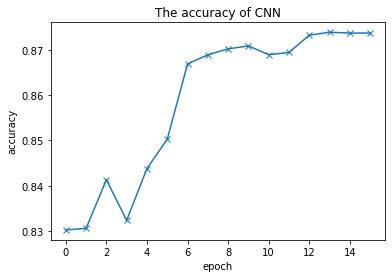

In [78]:
plot_accuracies(history)

In [79]:
#Graph of the loss vs. epoch
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

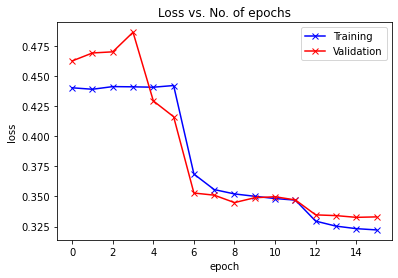

In [80]:
plot_losses(history)

In [81]:
#Graph of the learning rate vs. Batch no.
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

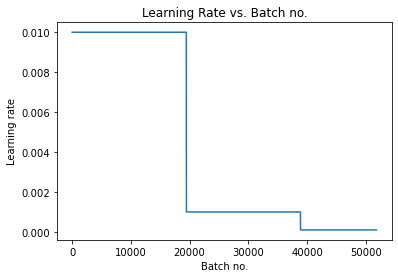

In [82]:
plot_lrs(history)

In [78]:
#Saving the model

In [79]:
torch.save(model.state_dict(), './EMNIST./zip/matlab/cnn.model')